# Improve Changepoint KDE

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
import sys
sys.path.append('../')

In [4]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [5]:
from eval.tsdr import load_tsdr_by_chaos

target_metric_types = {
    "services": True,
    "containers": True,
    "middlewares": True,
    "nodes": False,
}
dataset_by_chaos = load_tsdr_by_chaos(
    dataset_id=SOCKSHOP_DATASET_ID, 
    metric_types=target_metric_types,
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
)

In [153]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "user")][2]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape, record.chaos_case_file()

user/pod-cpu-hog/9n6mf-0


((180, 1328),
 '2023-02-17-argowf-chaos-9n6mf-user_pod-cpu-hog_0.json of user/pod-cpu-hog')

In [154]:
cause_container_cols = [record.pk.get_service_by_metric(metric) == record.pk.get_service_by_container(record.chaos_comp()) for metric in dataset.columns]
cause_dataset = dataset.loc[:, cause_container_cols]

In [155]:
comp_to_metrics_df = {}
series = dataset
for service, containers in record.pk.get_containers_of_service().items():
    metrics_dfs: list[pd.DataFrame] = []

    service_metrics_df = series.loc[
        :, series.columns.str.startswith(f"s-{service}_")
    ]
    if len(service_metrics_df.columns) > 0:
        metrics_dfs.append(service_metrics_df)

    for container in containers:
        container_metrics_df = series.loc[
            :,
            series.columns.str.startswith(
                (f"c-{container}_", f"m-{container}_")
            ),
        ]
        if len(container_metrics_df.columns) > 0:
            metrics_dfs.append(container_metrics_df)

    if len(metrics_dfs) > 0:
        comp_to_metrics_df[service] = pd.concat(metrics_dfs, axis=1)

In [156]:
cause_dataset

c-user-db_last_seen  c-user-db_memory_rss  \
0           3.353392e+09            60960768.0   
1           3.353392e+09            60555264.0   
2           3.353392e+09            61231104.0   
3           3.353392e+09            60825600.0   
4           3.353392e+09            61771776.0   
..                   ...                   ...   
175         3.353398e+09            63123456.0   
176         3.353398e+09            63123456.0   
177         3.353398e+09            65286144.0   
178         3.353398e+09            63123456.0   
179         3.353398e+09            63123456.0   

     c-user-db_cpu_system_seconds_total  c-user-db_threads  \
0                                0.0343              100.0   
1                                0.0239              100.0   
2                                0.0361              100.0   
3                                0.0350              100.0   
4                                0.0356              100.0   
..                                  ...                ...   
175                              0.0310              100.0   
176                              0.0314              100.0   
177                              0.0323              100.0   
178                              0.0332              100.0   
179                              0.0260              100.0   

     c-user-db_memory_working_set_bytes  c-user-db_fs_writes_bytes_total  \
0                           115621888.0                        2103.7494   
1                           115273728.0                        1822.6854   
2                           115707904.0                        2933.1839   
3                           115240960.0                        2433.5268   
4                           116609024.0                        2754.2615   
..                                  ...                              ...   
175                         117878784.0                        1521.3569   
176                         117915648.0                         897.9612   
177                         120205312.0                        1499.7140   
178                         117694464.0                        1611.8581   
179                         117694464.0                        1276.5922   

     c-user-db_network_transmit_packets_total  \
0                                    586.2870   
1                                    588.0671   
2                                    589.5922   
3                                    586.4552   
4                                    577.4002   
..                                        ...   
175                                  503.4503   
176                                  503.8474   
177                                  505.8154   
178                                  504.2143   
179                                  368.2780   

     c-user-db_network_receive_packets_total  c-user-db_cpu_cfs_periods_total  \
0                                   651.3137                           9.9895   
1                                   653.7935                          10.0048   
2                                   654.6955                          10.0181   
3                                   649.8171                          10.0074   
4                                   640.7606                           9.9893   
..                                       ...                              ...   
175                                 803.5014                           7.9025   
176                                 801.9988                          10.0093   
177                                 804.6801                          10.0019   
178                                 805.8451                           9.9987   
179                                 588.8558                           9.9987   

     c-user-db_network_receive_bytes_total  ...  \
0                              119004.6896  ...   
1                              119431.7315  ...   
2                              

In [226]:
from tsdr.multireducer import change_point_clustering, change_point_clustering_with_kde
from tsdr.clustering.changepoint import detect_univariate_changepoints, cluster_multi_changepoints
from eval.groundtruth import check_cause_metrics

cinfo, remove_metrics = change_point_clustering_with_kde(
    cause_dataset,
    search_method="bottomup",
    cost_model="l2",
    penalty="bic",
    # kde_bandwidth="scott",
    kde_bandwidth=1.0,
    kde_bandwidth_adjust=1.0,
    multi_change_points=True,
    representative_method=False,
    segment_selection_method="weighted_max",
    n_jobs=-1,
)
keep_metrics = list(cinfo.keys())
print(keep_metrics)

check_cause_metrics(record.pk, keep_metrics, chaos_type=record.chaos_type(), chaos_comp=record.chaos_comp(), optional_cause=False)


['m-user-db_mongodb_ss_logicalSessionRecordCache_sessionsCollectionJobCount', 'm-user-db_mongodb_sys_cpu_ctxt', 'm-user-db_mongodb_sys_cpu_user_ms', 'm-user-db_mongodb_ss_network_physicalBytesIn', 'm-user-db_mongodb_ss_locks_acquireCount', 'm-user-db_mongodb_sys_cpu_system_ms', 'm-user-db_mongodb_ss_tcmalloc_tcmalloc_pageheap_unmapped_bytes', 'm-user-db_mongodb_ss_metrics_document', 'm-user-db_mongodb_ss_network_physicalBytesOut', 'm-user-db_mongodb_sys_netstat_TcpExt_TCPAbortOnClose', 'm-user-db_mongodb_sys_netstat_TcpExt_TCPDelivered', 'm-user-db_mongodb_ss_wt_txn_transaction_begins', 'm-user-db_mongodb_ss_wt_cursor_cursor_search_calls', 'm-user-db_mongodb_sys_netstat_IpExt_InNoECTPkts', 'c-user_memory_usage_bytes', 'm-user-db_mongodb_ss_wt_perf', 'm-user-db_mongodb_top_queries_count', 'm-user-db_mongodb_ss_tcmalloc_tcmalloc_spinlock_total_delay_ns', 'm-user-db_mongodb_ss_wt_cursor_cursor_sweep_cursors_examined', 'm-user-db_mongodb_sys_netstat_TcpExt_TCPOrigDataSent', 'c-user-db_cpu_

(True,
 c-user_cpu_user_seconds_total,c-user_cpu_usage_seconds_total,c-user_threads)

In [210]:
# Load raw data
# from meltria import loader

# raw_record = loader.read_metrics_file(
#     "/datasets/argowf-chaos-9n6mf/argowf-chaos-9n6mf/" + record.basename_of_metrics_file(), target_metric_types=target_metric_types, num_datapoints=180, interporate=False)

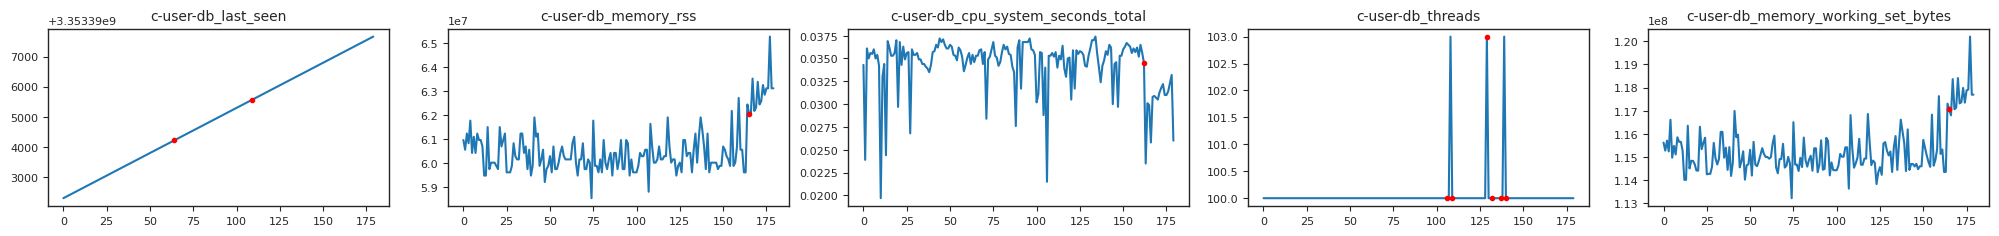

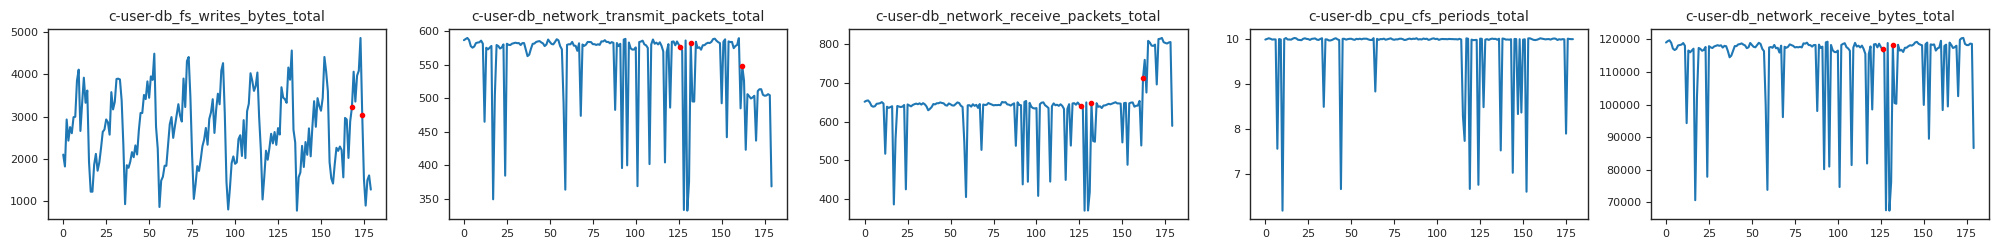

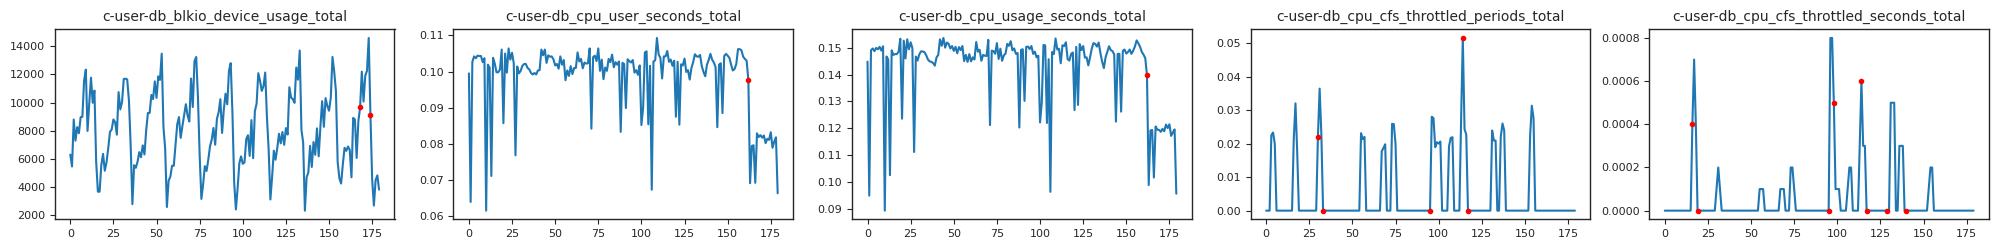

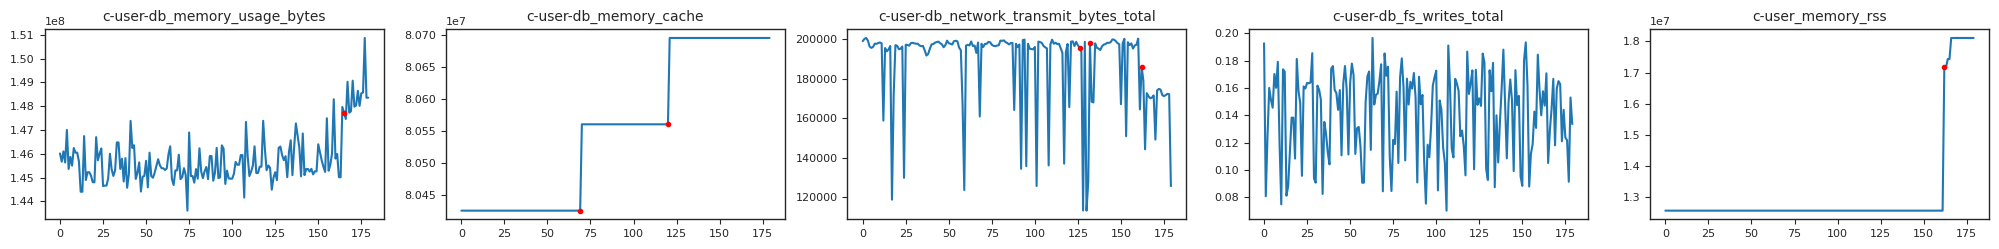

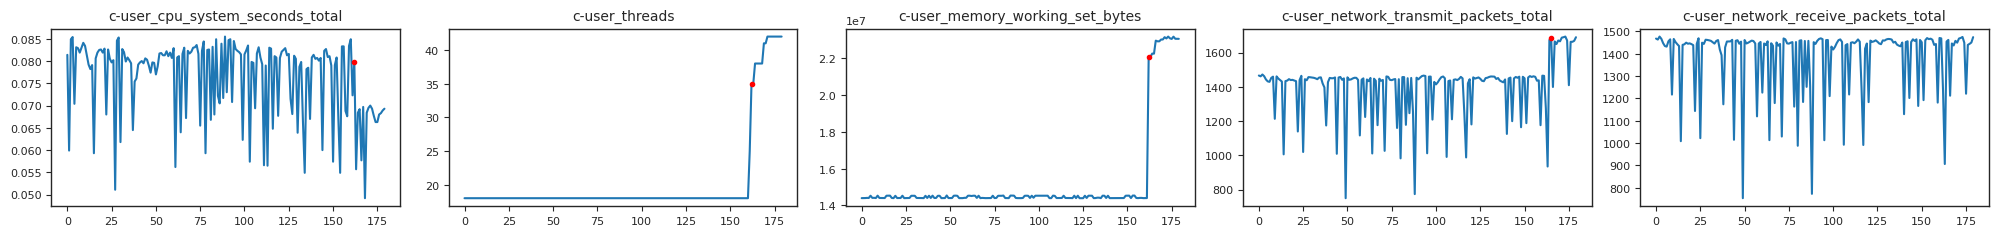

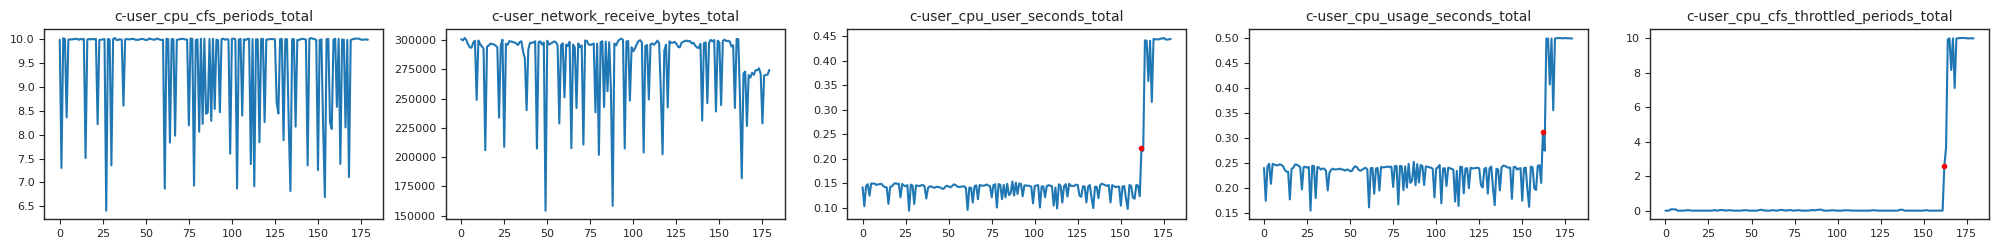

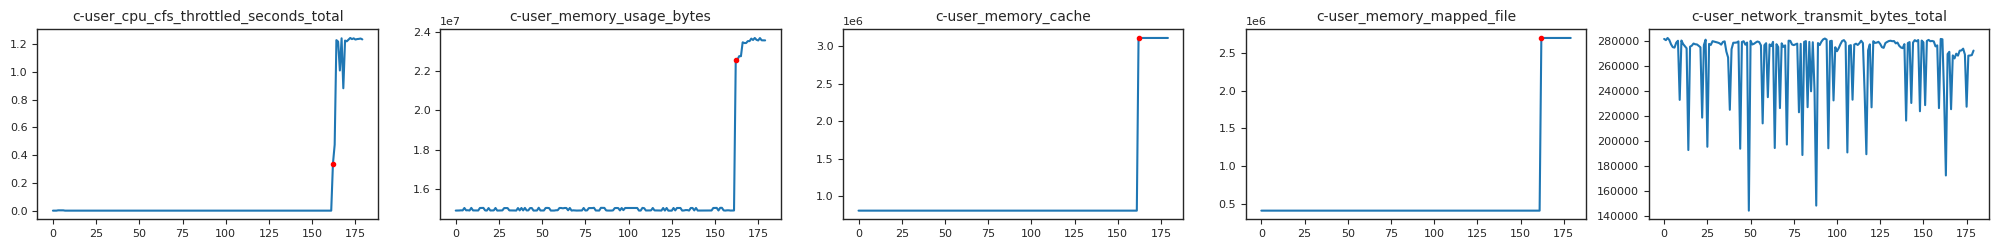

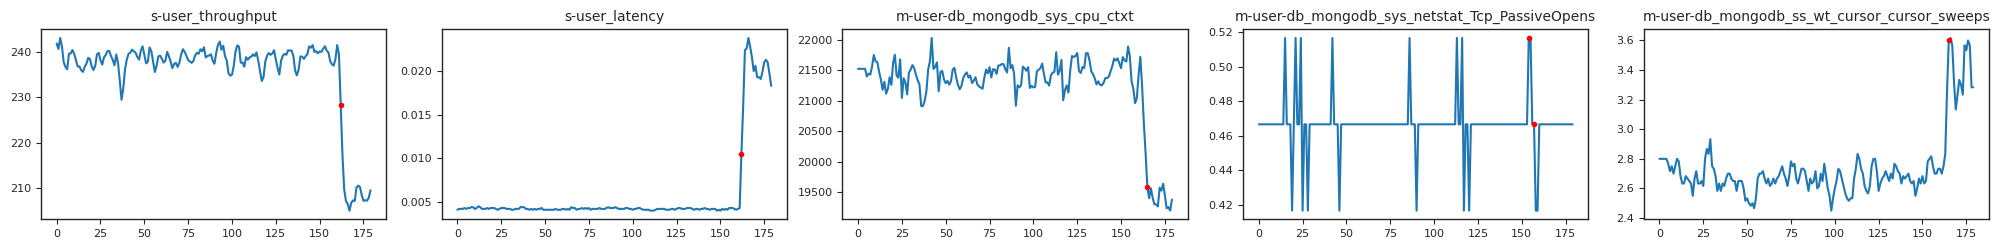

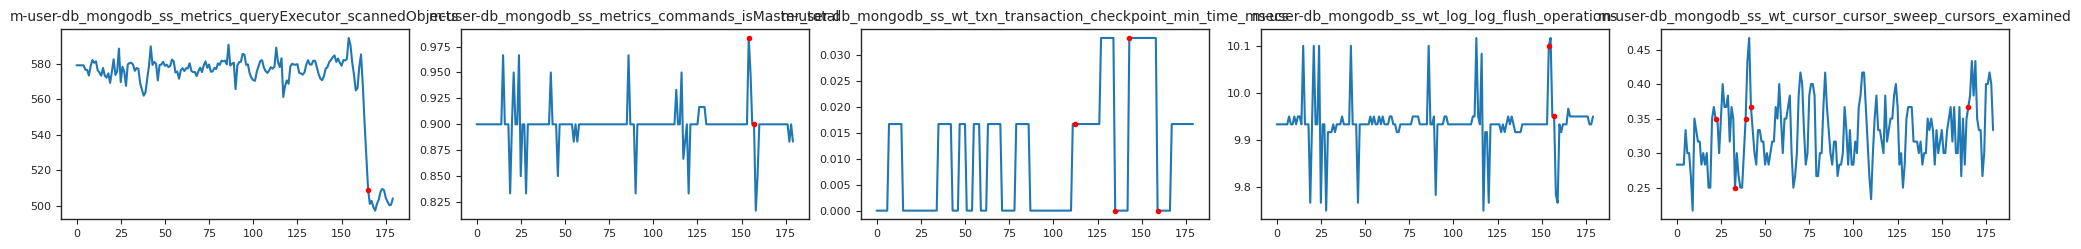

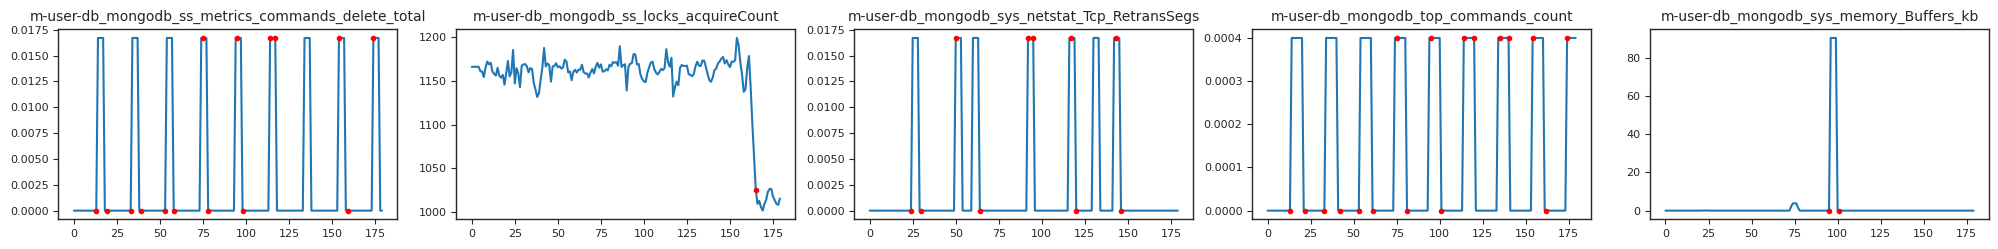

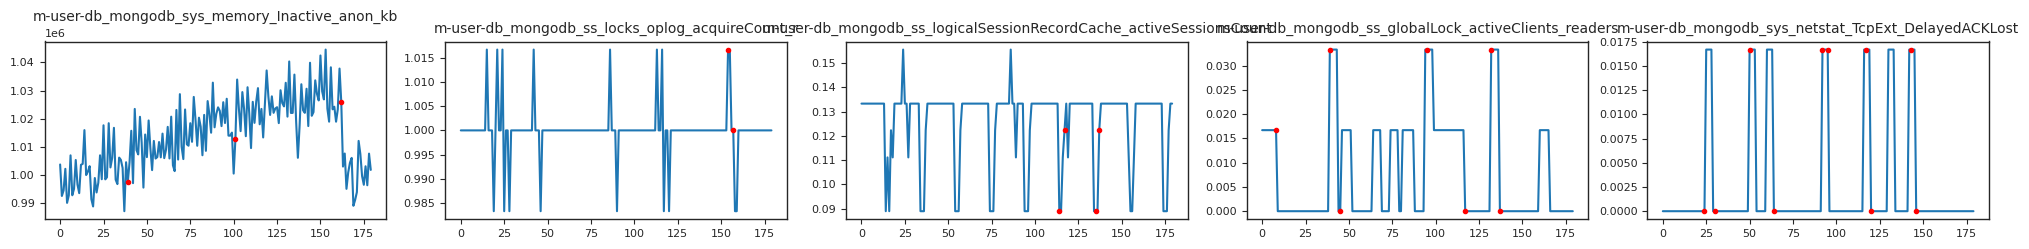

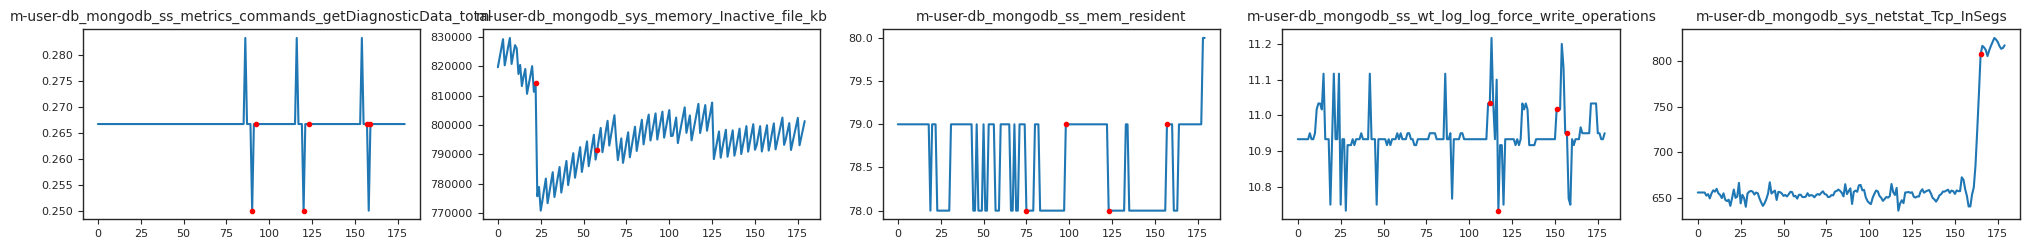

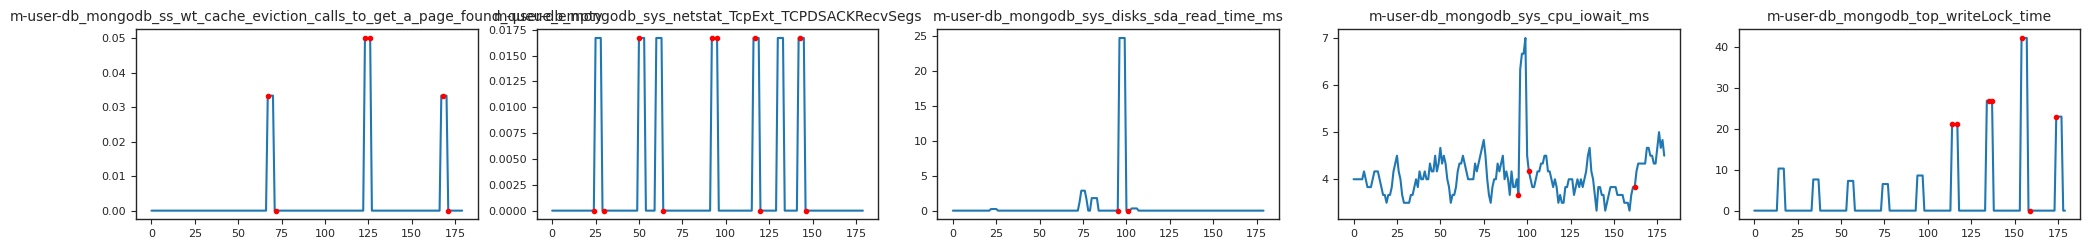

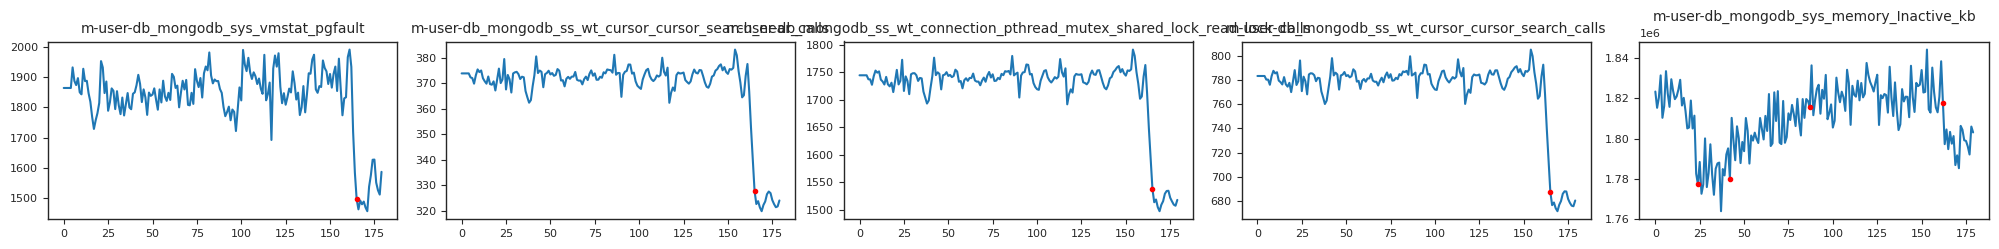

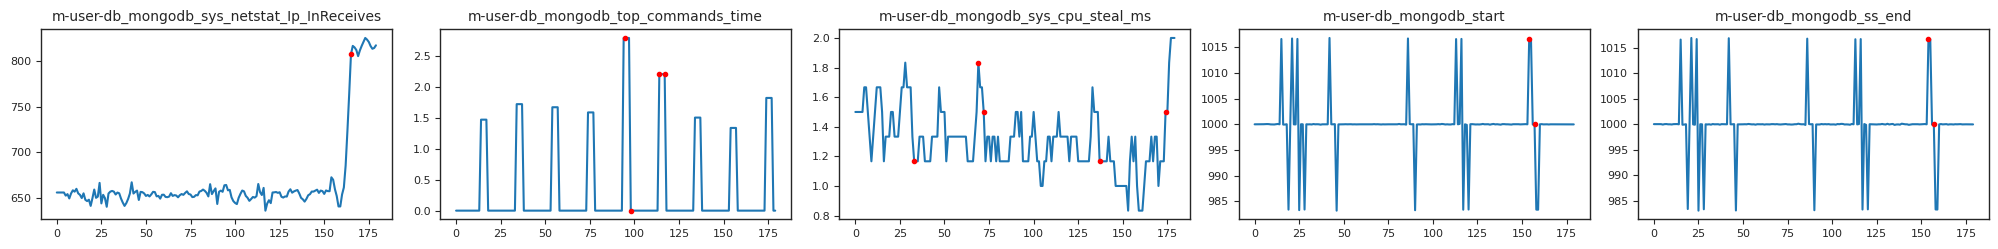

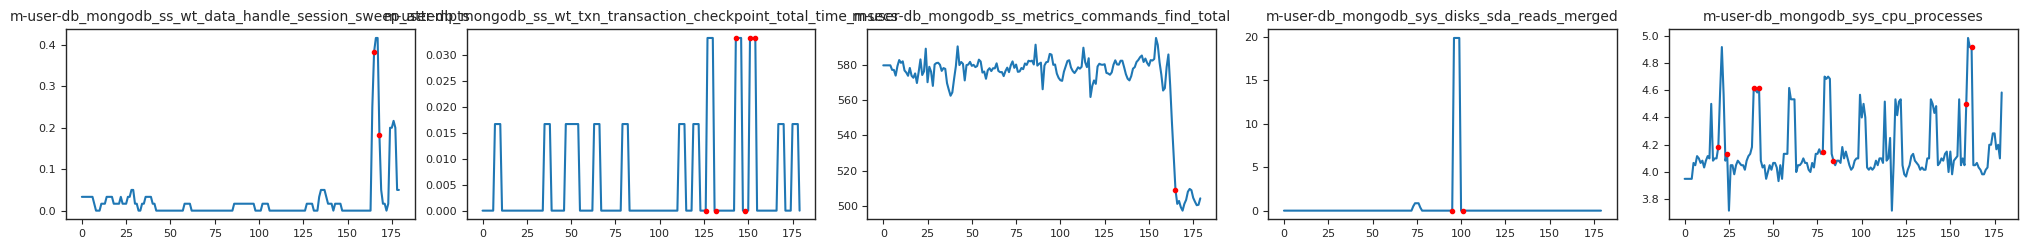

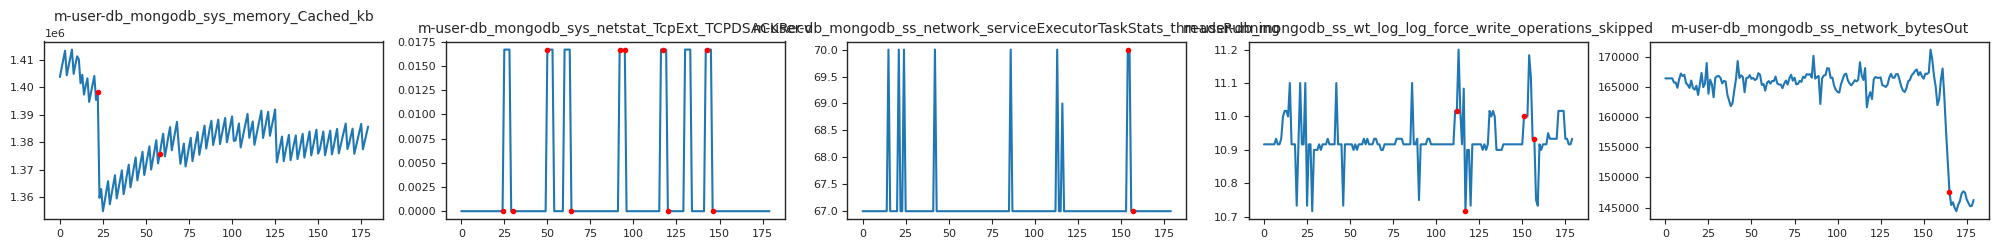

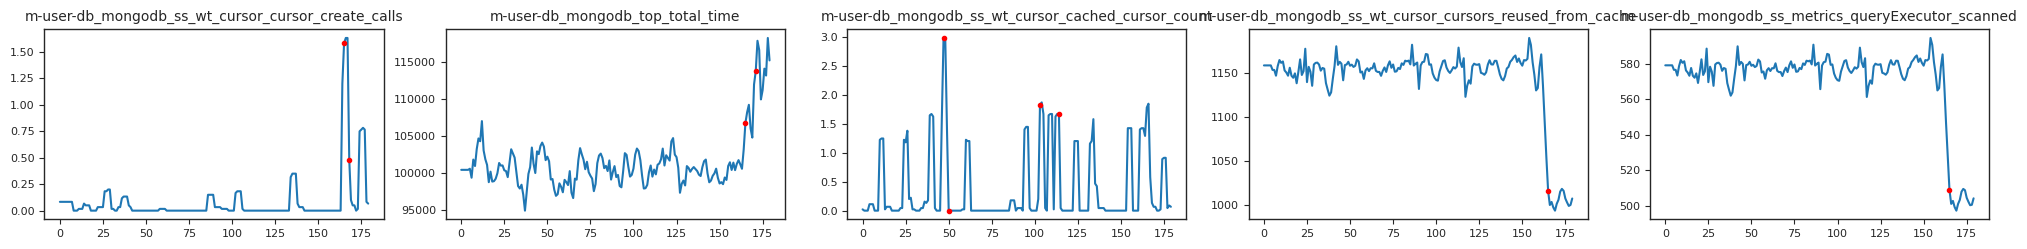

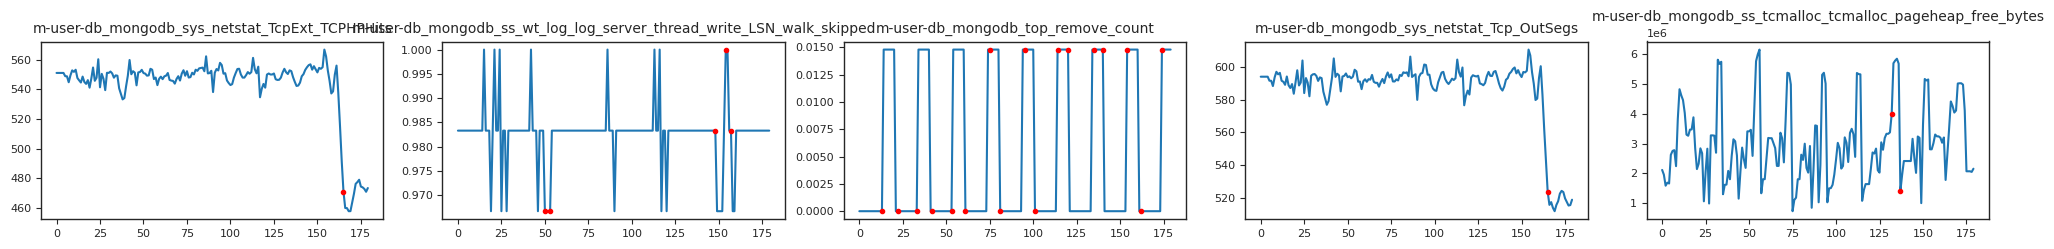

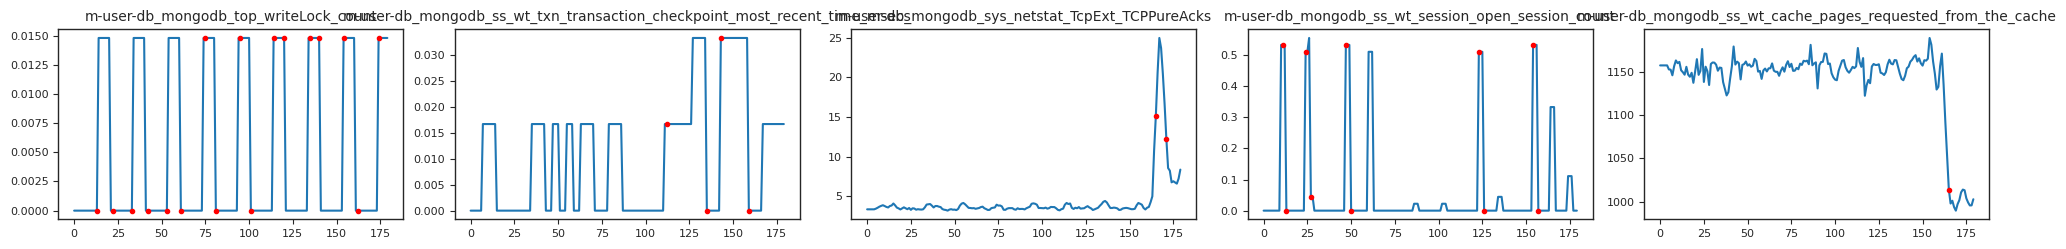

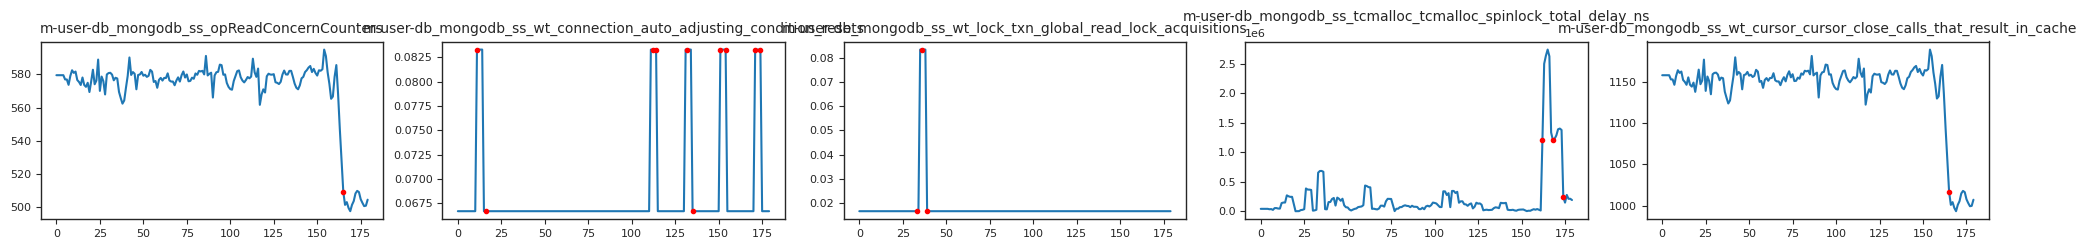

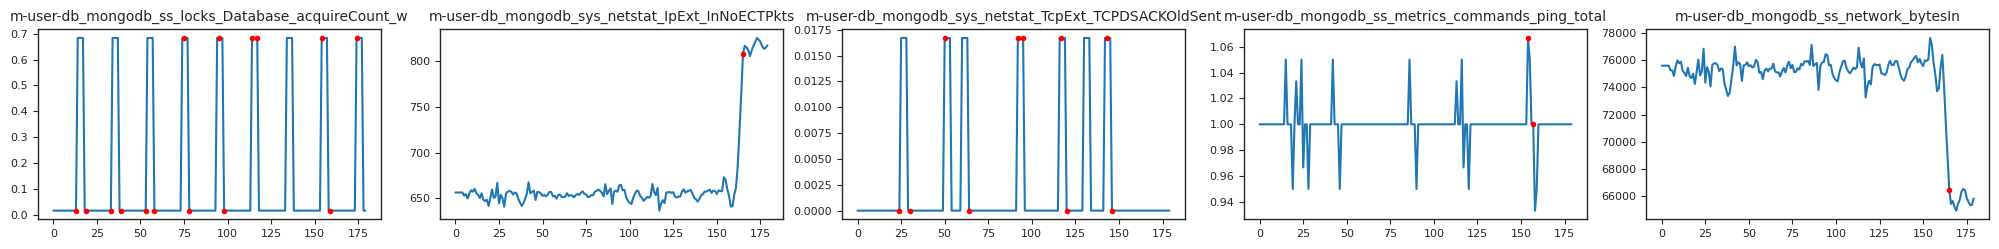

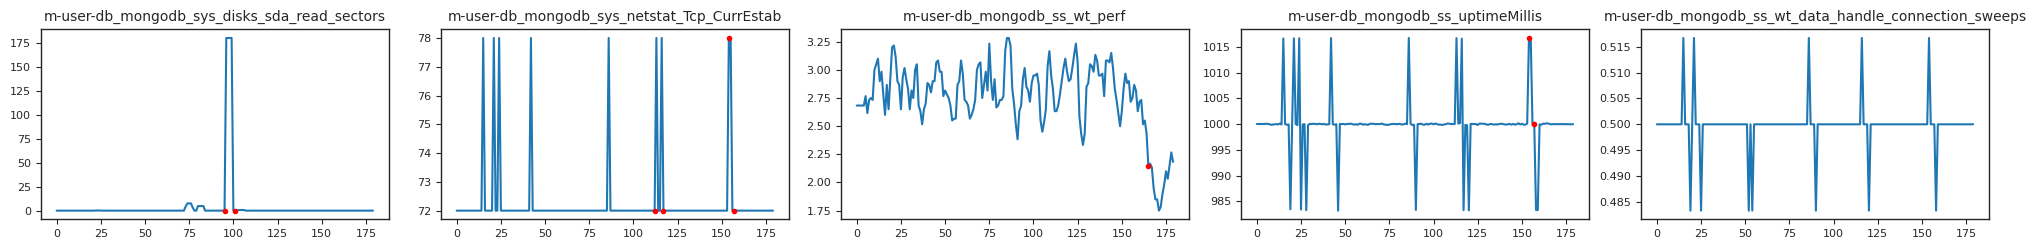

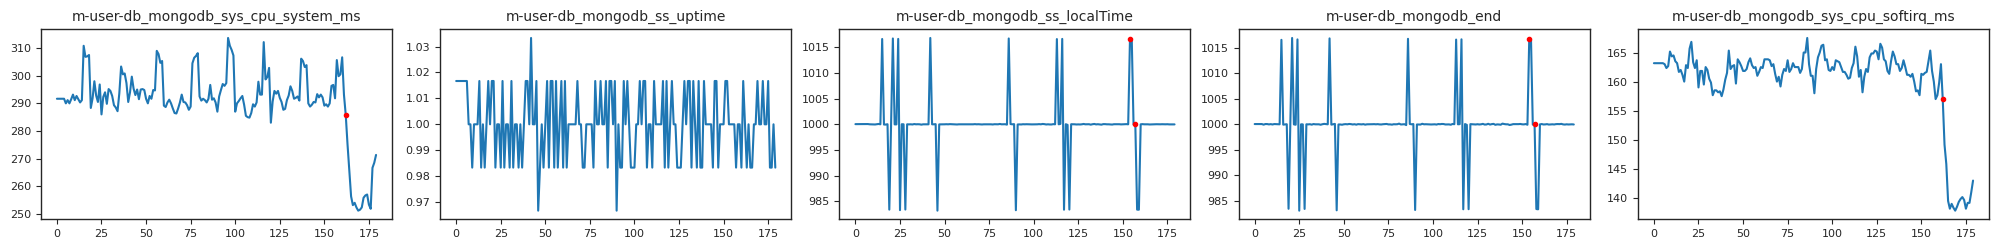

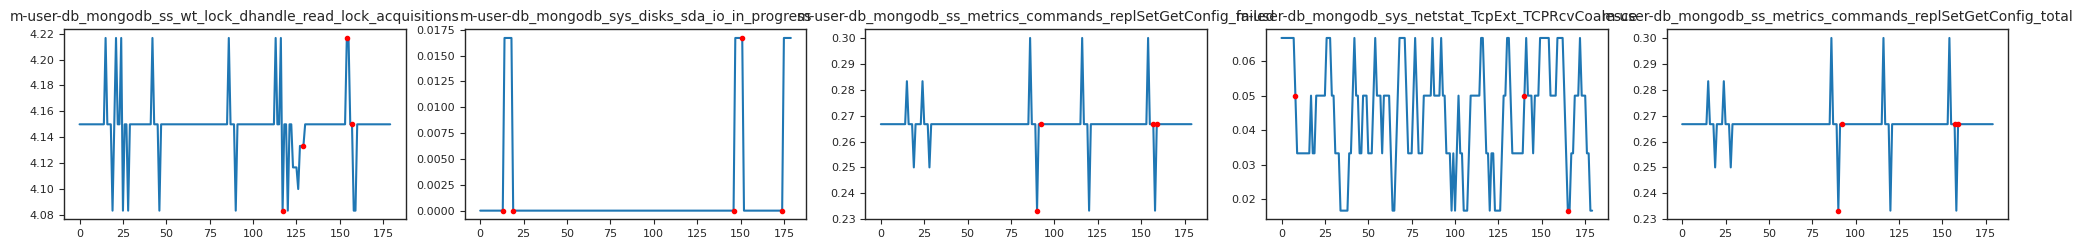

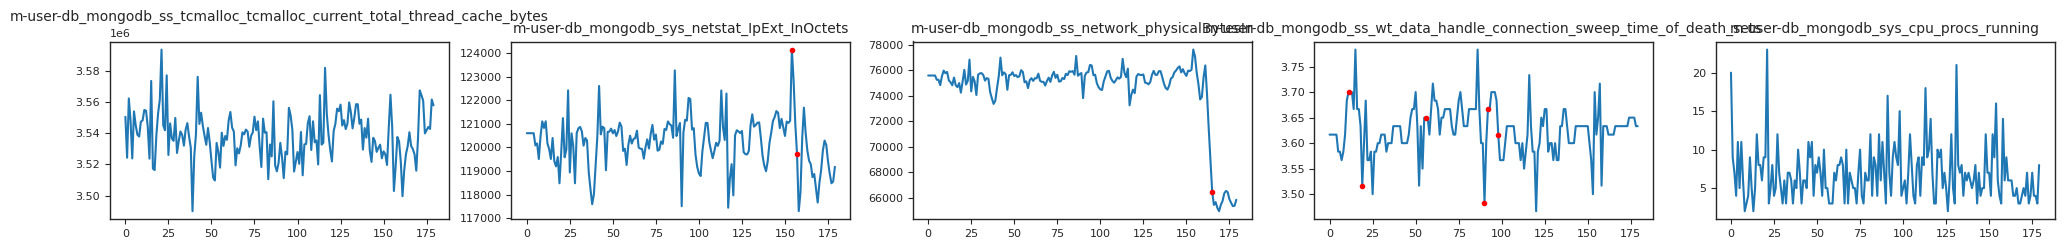

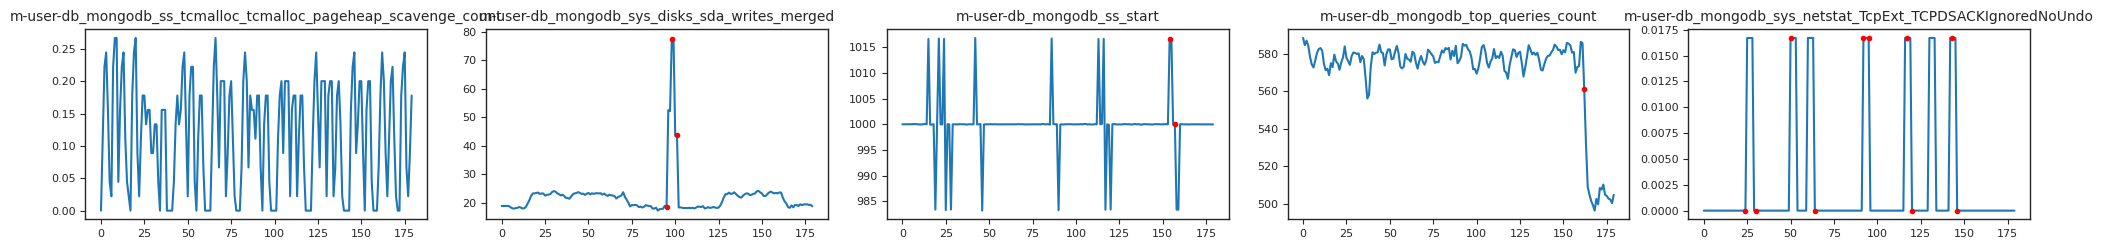

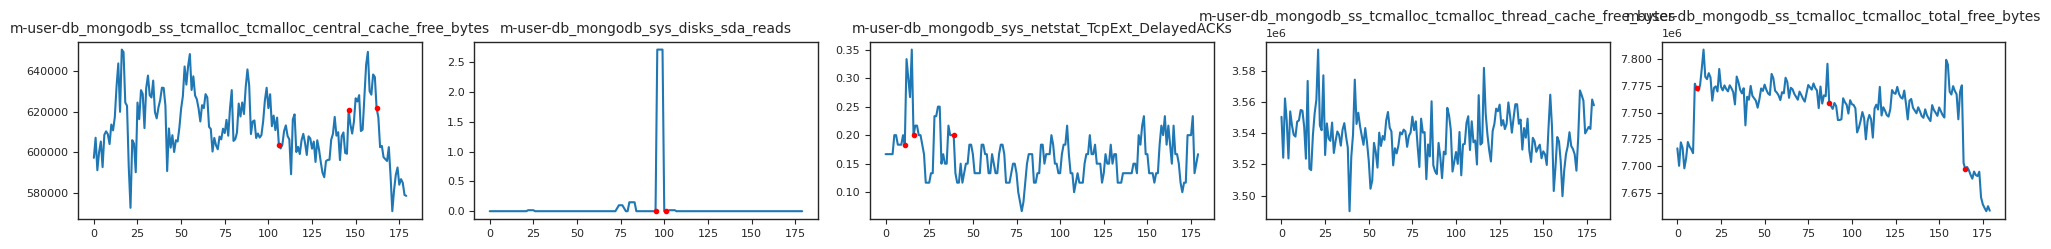

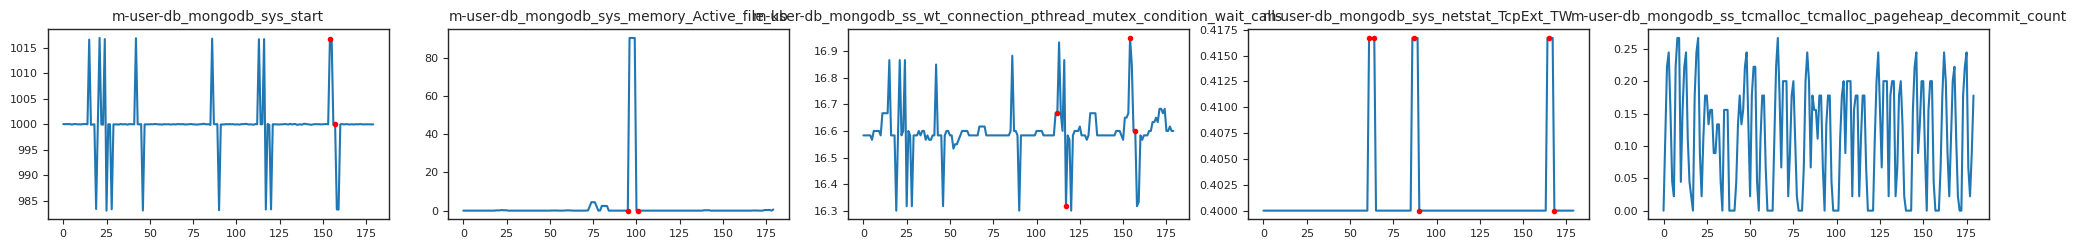

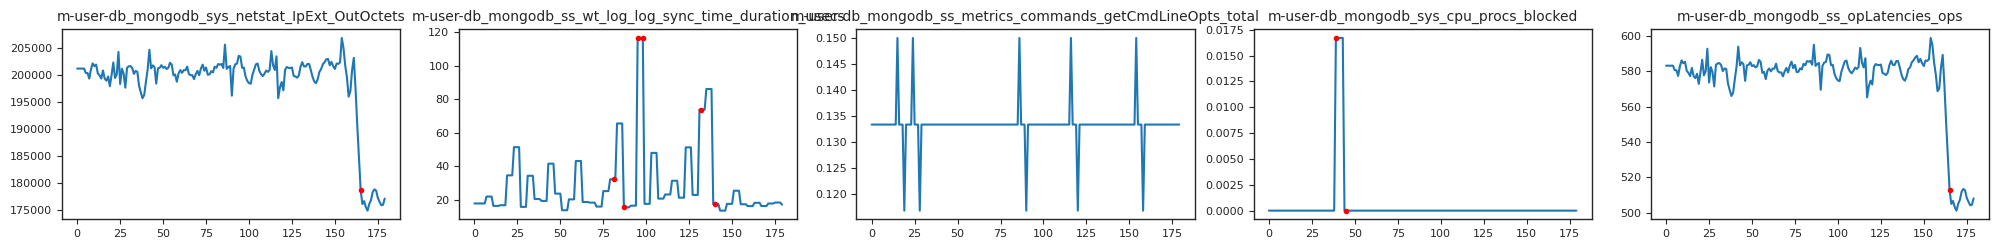

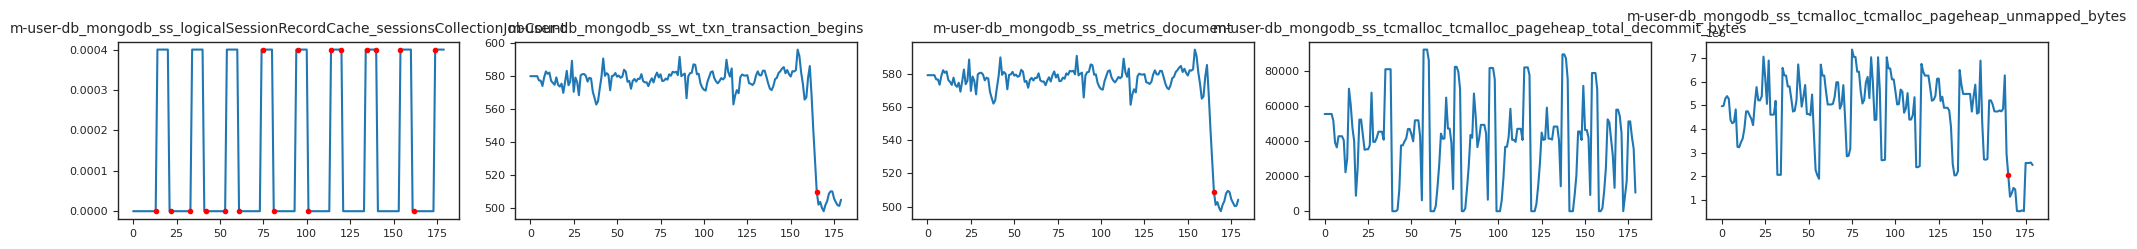

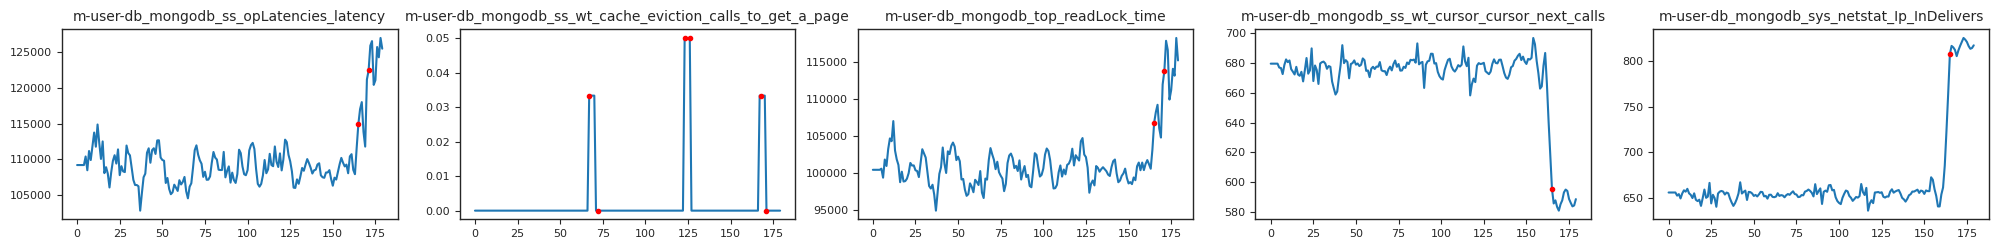

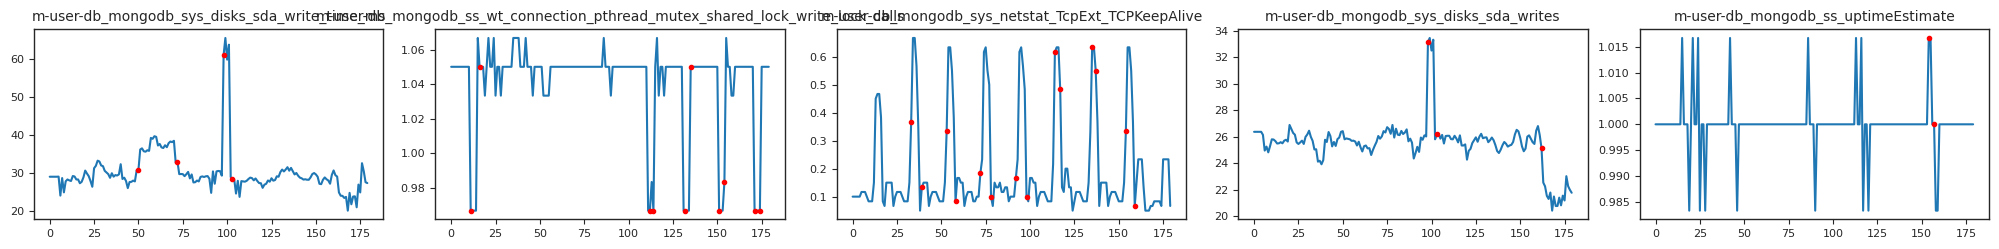

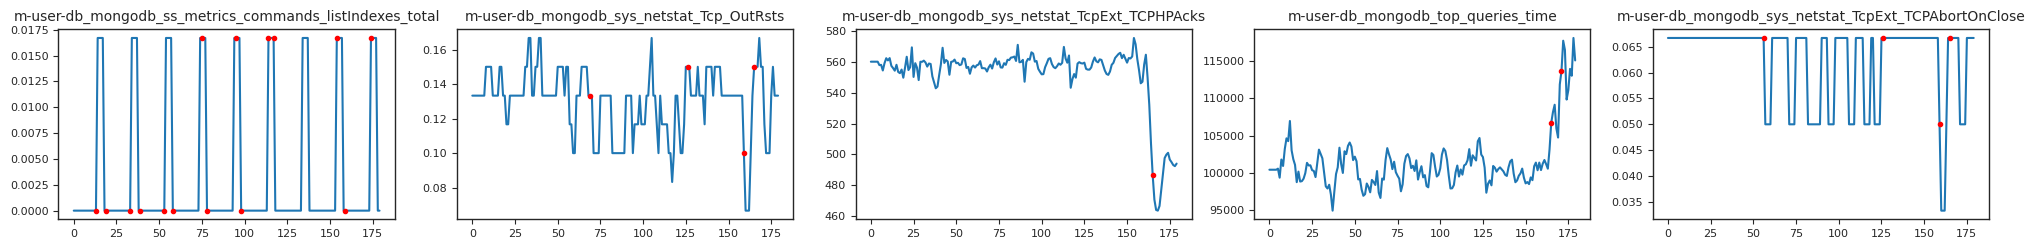

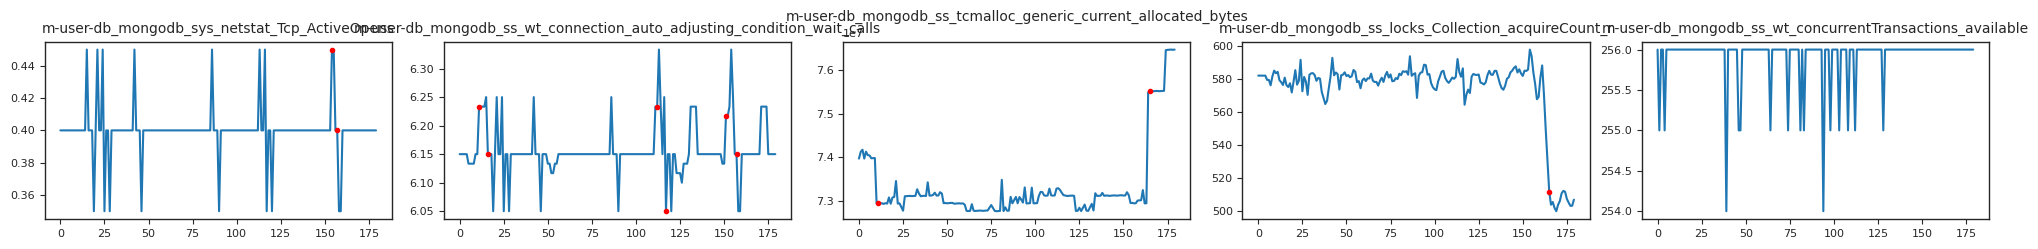

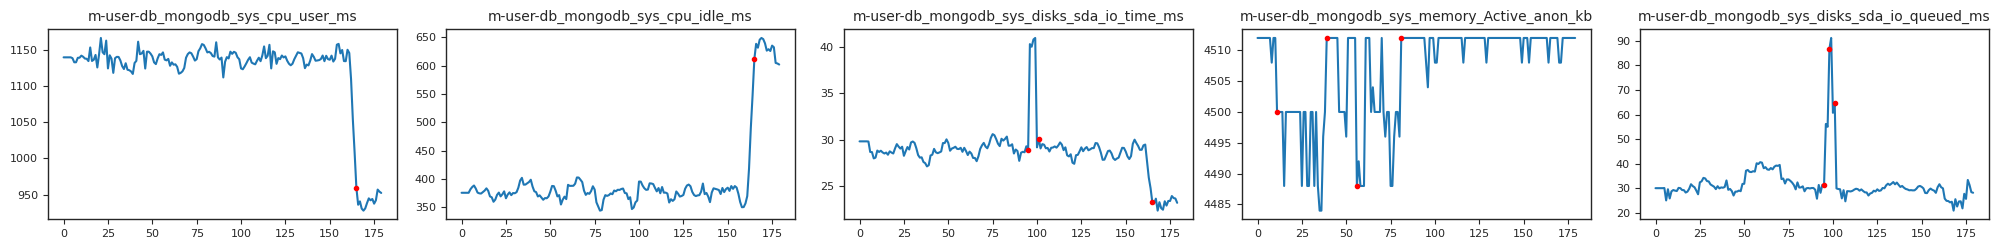

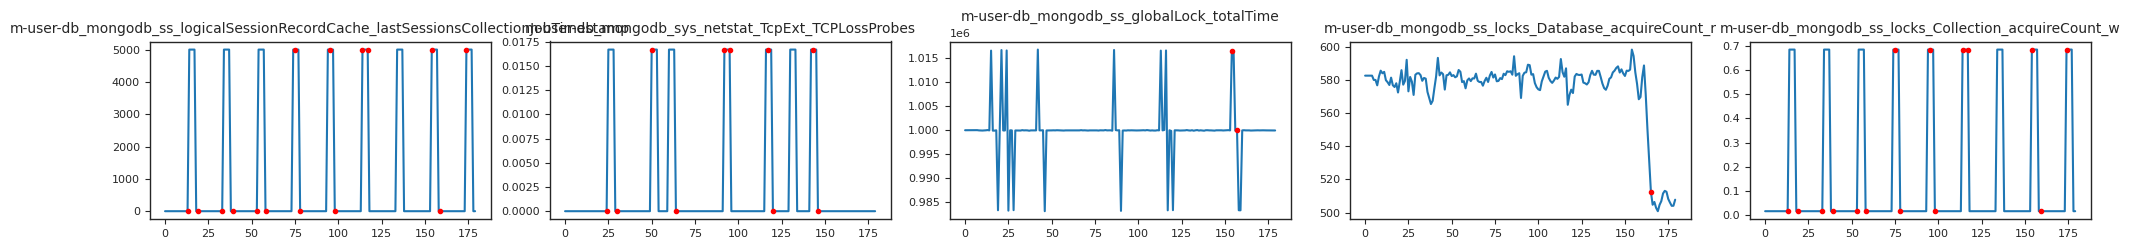

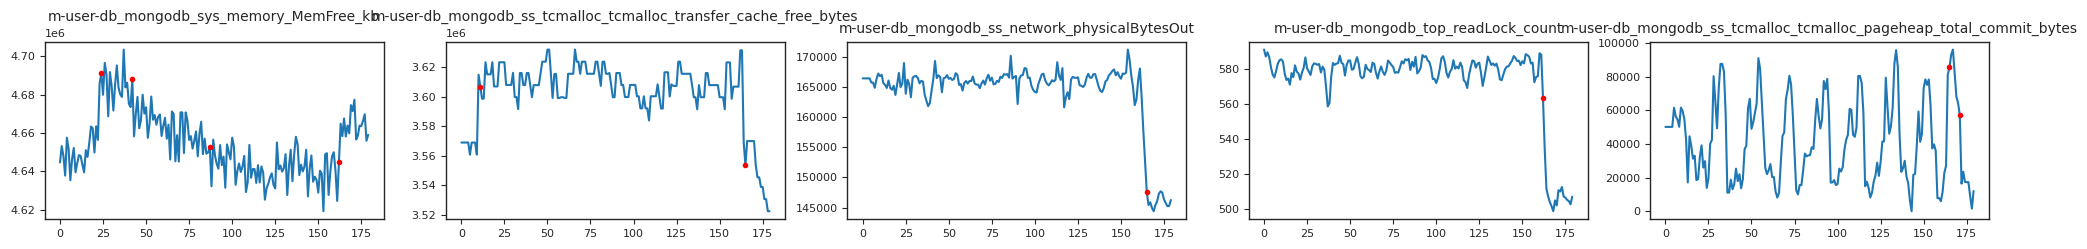

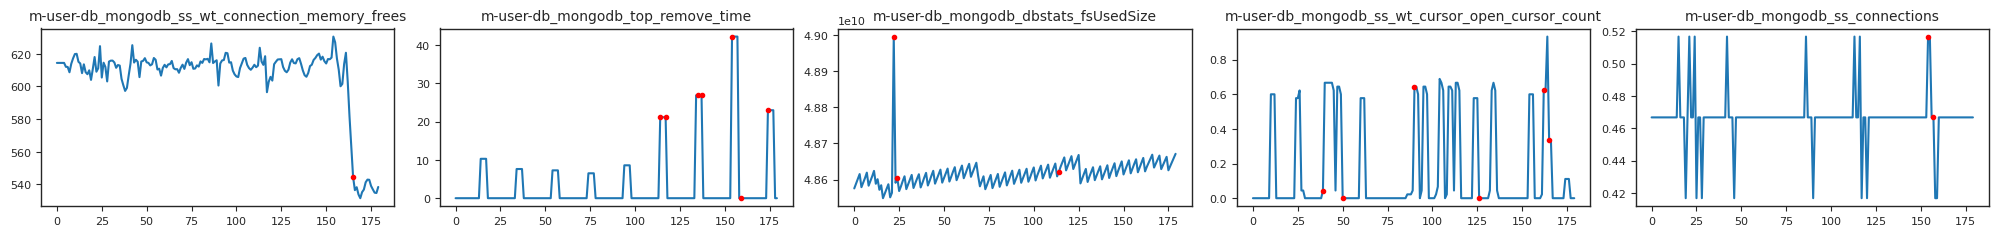

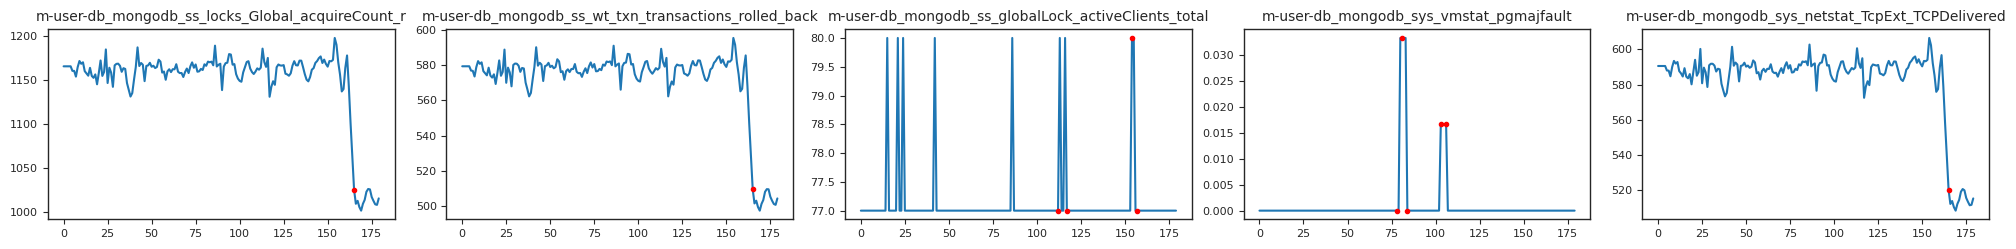

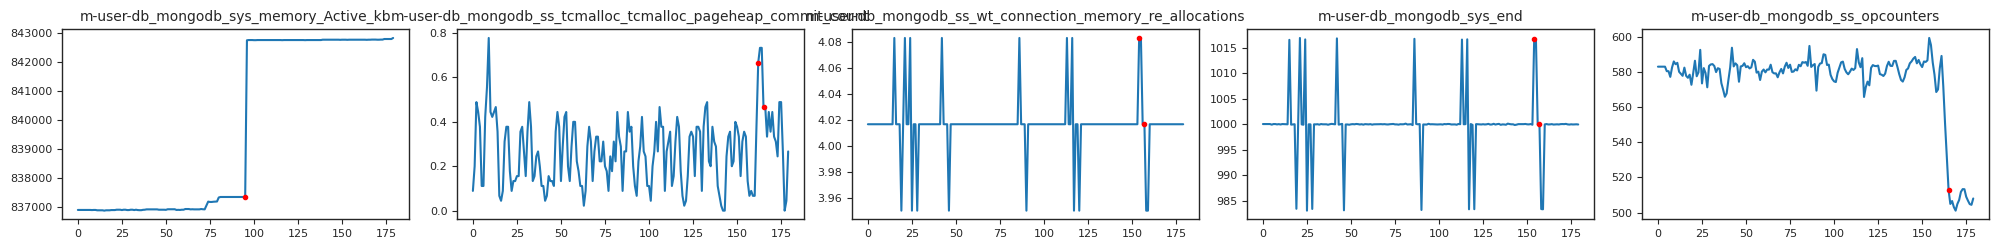

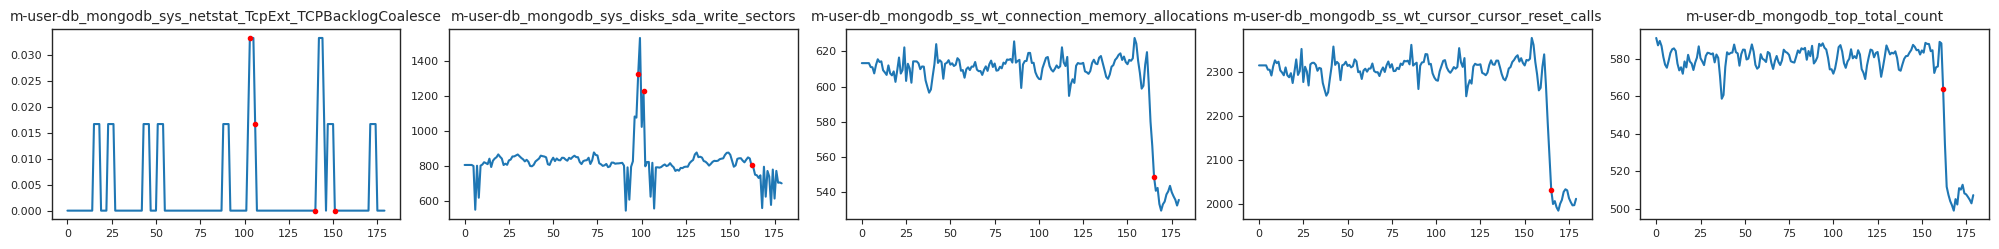

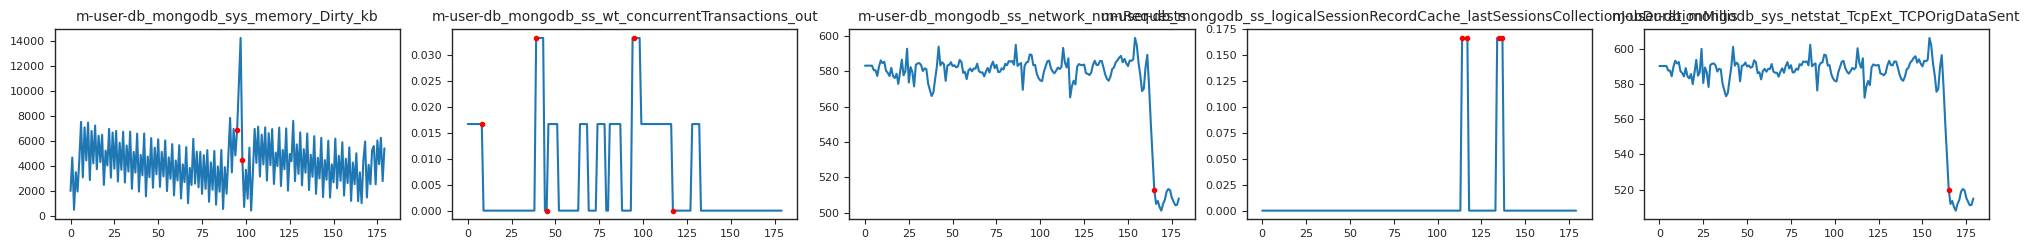

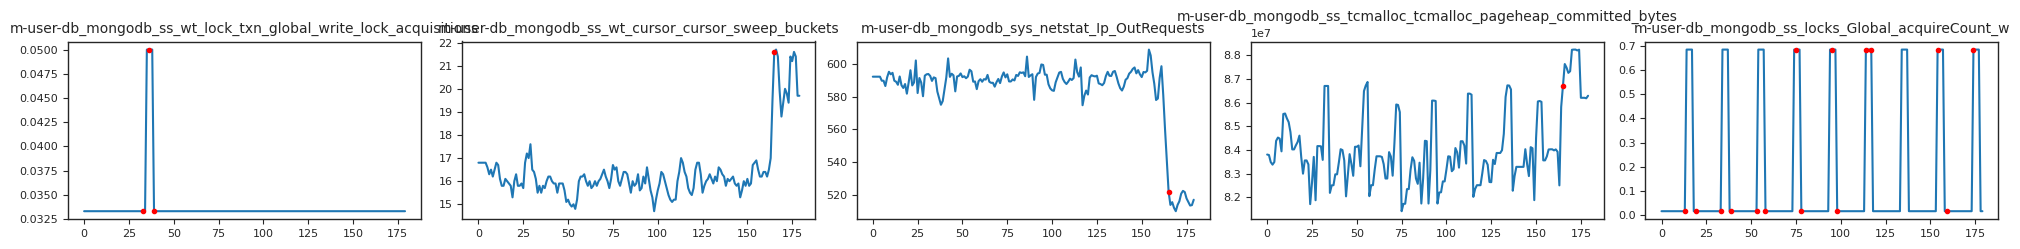

In [211]:
import seaborn as sns

def batch(iterable, n):
    length = len(iterable)
    for i in range(0, length, n):
        yield iterable[i:min(i + n, length)]


multi_changepoints = []
num_per_row = 5
for __metrics in batch(cause_dataset.columns.tolist(), num_per_row):
    fig, axs = plt.subplots(1, num_per_row, figsize=(20, 2.5))
    for __metric, ax in zip(__metrics, axs):
        # x = raw_record.data_df[__metric].to_numpy()
        x = cause_dataset[__metric].to_numpy()
        sns.lineplot(x=range(len(x)), y=x, ax=ax)

        cps = detect_univariate_changepoints(x, search_method="bottomup", cost_model="l2", penalty="bic")
        multi_changepoints.append(cps)
        ax.set_title(__metric, fontsize=10)
        if len(cps) > 0:
            ax.plot(cps, x[cps], 'o', color='red', markersize=3)
    fig.tight_layout()
    plt.show()
    fig.clf()
    plt.close(fig=fig)

In [212]:
label_to_metrics, label_to_change_points = cluster_multi_changepoints(
    multi_changepoints, metrics=cause_dataset.columns.tolist(), kde_bandwidth="scott", kde_bandwidth_adjust=0.02, time_series_length=180)
label_to_metrics, label_to_change_points, {k: len(v) for k, v in label_to_metrics.items()}

(defaultdict(set,
             {0: {'m-user-db_mongodb_ss_globalLock_activeClients_readers',
               'm-user-db_mongodb_ss_wt_concurrentTransactions_out',
               'm-user-db_mongodb_sys_netstat_TcpExt_TCPRcvCoalesce'},
              1: {'m-user-db_mongodb_ss_tcmalloc_generic_current_allocated_bytes',
               'm-user-db_mongodb_ss_tcmalloc_tcmalloc_total_free_bytes',
               'm-user-db_mongodb_ss_tcmalloc_tcmalloc_transfer_cache_free_bytes',
               'm-user-db_mongodb_ss_wt_connection_auto_adjusting_condition_resets',
               'm-user-db_mongodb_ss_wt_connection_auto_adjusting_condition_wait_calls',
               'm-user-db_mongodb_ss_wt_connection_pthread_mutex_shared_lock_write_lock_calls',
               'm-user-db_mongodb_ss_wt_data_handle_connection_sweep_time_of_death_sets',
               'm-user-db_mongodb_ss_wt_session_open_session_count',
               'm-user-db_mongodb_sys_memory_Active_anon_kb',
               'm-user-db_mongodb_sy

In [213]:
from collections import defaultdict

NO_CHANGE_POINTS = -1
cp_to_metrics: dict[int, list[str]] = defaultdict(list)
for metric, change_points in zip(cause_dataset.columns, multi_changepoints):
    if len(change_points) < 1:
        cp_to_metrics[NO_CHANGE_POINTS].append(metric)  # cp == -1 means no change point
        continue
    for cp in change_points:
        cp_to_metrics[cp].append(metric)

flatten_change_points: list[int] = sum(multi_changepoints, [])
time_series_length = cause_dataset.shape[0]
x = np.array(flatten_change_points, dtype=int)

### sklearn

[ 64 109 165 162 106 109 129 132 137 140 165 168 174 126 132 162 126 132
 162 126 132 168 174 162 162  30  33  95 114 117  16  19  95  98 114 117
 129 140 165  69 120 126 132 162 162 162 162 162 165 162 162 162 162 162
 162 162 162 162 165 154 157 165 165 154 157 112 135 143 159 154 157  22
  33  39  42 165  13  19  33  39  53  58  75  78  95  98 114 117 154 159
 174 165  24  30  50  64  92  95 117 120 143 146  13  22  33  42  53  61
  75  81  95 101 114 120 135 140 154 162 174  95 101  39 101 162 154 157
 114 117 135 137   8  39  45  95 117 132 137  24  30  50  64  92  95 117
 120 143 146  90  92 120 123 157 159  22  58  75  98 123 157 112 117 151
 157 165  67  72 123 126 168 171  24  30  50  64  92  95 117 120 143 146
  95 101  95 101 162 114 117 135 137 154 159 174 165 165 165 165  24  42
  87 162 165  95  98 114 117  33  69  72 137 174 154 157 154 157 165 168
 126 132 143 148 151 154 165  95 101  19  24  39  42  78  84 159 162  22
  58  24  30  50  64  92  95 117 120 143 146 154 15

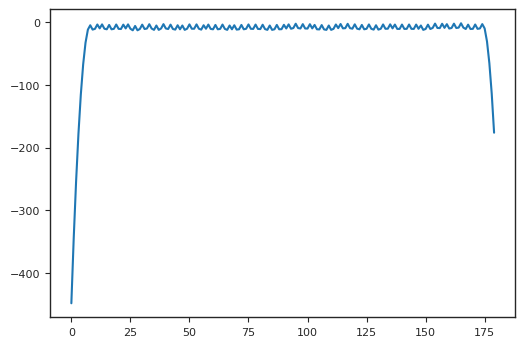

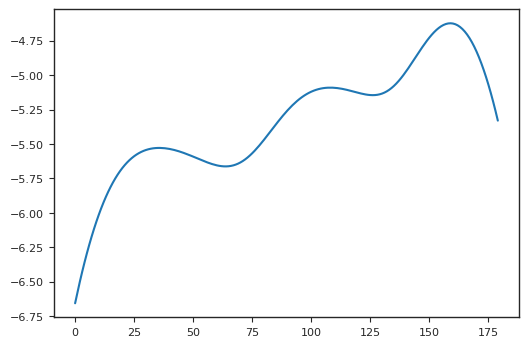

In [214]:
from sklearn.neighbors import KernelDensity
import scipy

kde_bandwidth = "scott"
iqr = np.quantile(x, 0.75) - np.quantile(x, 0.25)
sigma = min(x.std(), iqr / 1.34)
print(x, np.std(x), sigma)
match kde_bandwidth:
    case "silverman":
        kde_bandwidth = 0.9 * sigma * (len(x) ** (-1 / 5.))
    case "scott":
        kde_bandwidth = 1.06 * sigma * (len(x) ** (-1 / 5.))
    case _:
        pass
print(f"KDE bandwidth: {kde_bandwidth}")

kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(x.reshape(-1, 1))
print(kde.bandwidth_, kde.bandwidth)
s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
e = kde.score_samples(s.reshape(-1, 1))
# e = np.log(kde(s))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(e)

kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth).fit(x.reshape(-1, 1))
print(kde.bandwidth_, kde.bandwidth)
s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
e = kde.score_samples(s.reshape(-1, 1))
# e = np.log(kde(s))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(e)

### scipy

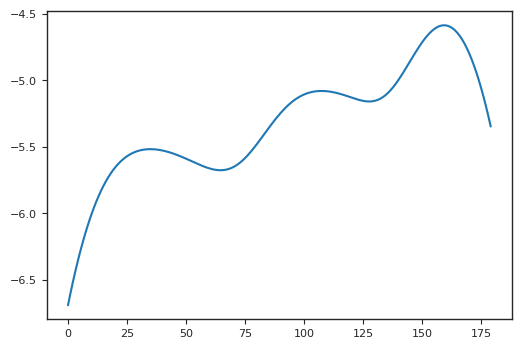

In [215]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(x, bw_method="scott")
s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
e = kde.logpdf(s)
# e = np.log(kde(s))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(e)

### statsmodels

14.206992295006685 scott
14.209995229903551 normal_reference
0.5682796918002674 scott 0.04


Text(0.5, 1.0, 'adjust=0.04')

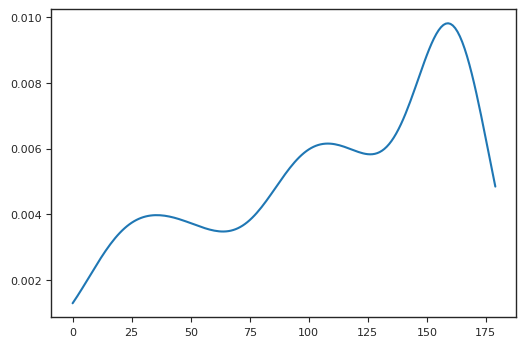

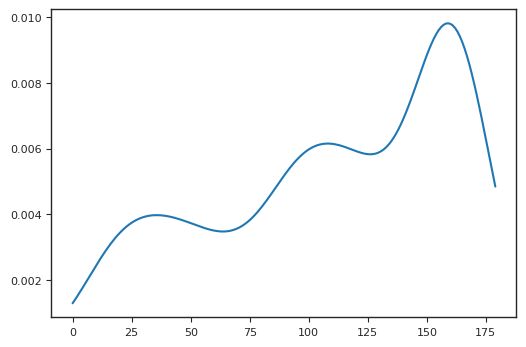

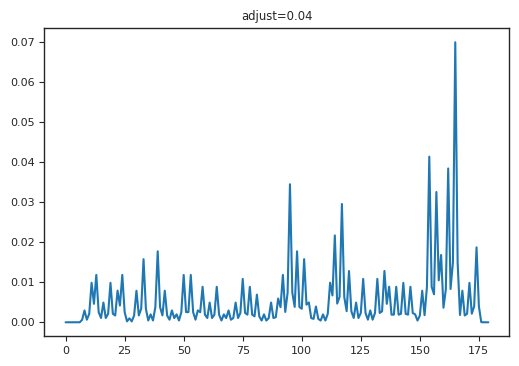

In [216]:
from statsmodels.nonparametric.kde import KDEUnivariate

dens = KDEUnivariate(x)
dens.fit(bw="scott", kernel="gau")
print(dens.bw, dens.bw_method)

s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(dens.evaluate(s))


dens = KDEUnivariate(x)
dens.fit(bw="normal_reference", kernel="gau")
print(dens.bw, dens.bw_method)

s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(dens.evaluate(s))


adjust = 0.04
dens = KDEUnivariate(x)
dens.fit(bw="scott", kernel="gau", adjust=adjust)
print(dens.bw, dens.bw_method, adjust)

s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
e = dens.evaluate(s)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(e)
ax.set_title(f"adjust={adjust}")

In [217]:
from scipy.signal import argrelextrema

mi = argrelextrema(e, np.less)[0]
clusters = []
if len(mi) <= 0:
    clusters.append(np.arange(len(x)))
else:
    clusters.append(np.where(x < s[mi][0])[0])  # most left cluster
    for i_cluster in range(len(mi) - 1):  # all middle cluster
        clusters.append(np.where((x >= s[mi][i_cluster]) * (x <= s[mi][i_cluster + 1]))[0])
    clusters.append(np.where(x >= s[mi][-1])[0])  # most right cluster

labels = np.zeros(len(x), dtype=int)
for label, x_args in enumerate(clusters):
    clusters[label] = np.unique(x[x_args])
    labels[x_args] = label
label_to_values: dict[int, np.ndarray] = {label: vals for label, vals in enumerate(clusters)}
label_to_values

{0: array([8]),
 1: array([11]),
 2: array([13]),
 3: array([16]),
 4: array([19]),
 5: array([22]),
 6: array([24]),
 7: array([27]),
 8: array([30]),
 9: array([33]),
 10: array([36]),
 11: array([39]),
 12: array([42]),
 13: array([45]),
 14: array([47]),
 15: array([50]),
 16: array([53]),
 17: array([56]),
 18: array([58]),
 19: array([61]),
 20: array([64]),
 21: array([67]),
 22: array([69]),
 23: array([72]),
 24: array([75]),
 25: array([78]),
 26: array([81]),
 27: array([84]),
 28: array([87]),
 29: array([90]),
 30: array([92]),
 31: array([95]),
 32: array([98]),
 33: array([101]),
 34: array([103]),
 35: array([106]),
 36: array([109]),
 37: array([112]),
 38: array([114]),
 39: array([117]),
 40: array([120]),
 41: array([123]),
 42: array([126]),
 43: array([129]),
 44: array([132]),
 45: array([135]),
 46: array([137]),
 47: array([140]),
 48: array([143]),
 49: array([146, 148]),
 50: array([151]),
 51: array([154]),
 52: array([157]),
 53: array([159]),
 54: array([1

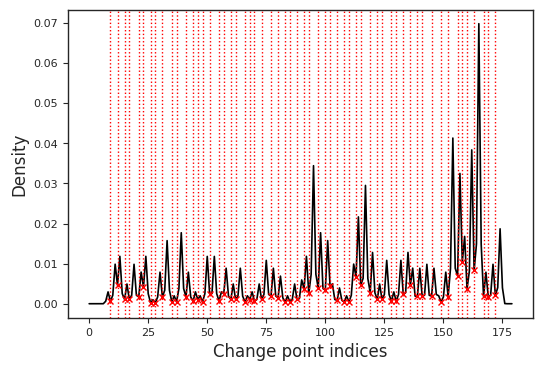

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.set_style("ticks")
sns.lineplot(x=s, y=e, ax=ax, color='black', linewidth=1.2)
ax.plot(s[mi], e[mi], 'x', color='red', markersize=4)
# ax.vlines(x=s[mi], ymin=min(e[mi])-100, ymax=100, color='red', linestyles='dotted', linewidth=1.0)
for v in s[mi]:
    ax.axvline(x=v, color='red', linestyle='dotted', linewidth=1.0) 
ax.set_xlabel("Change point indices", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
fig.savefig("./materials/kde_samples.pdf", format="pdf", dpi=400, bbox_inches="tight")
plt.show()
fig.clf()
plt.close(fig)